Librerías

In [1]:
import os
import pandas as pd
from dotenv import load_dotenv
from sqlalchemy import create_engine
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt 

Conexión con base de datos

In [2]:
load_dotenv()


user = os.getenv('DB_USER')
password = os.getenv('DB_PASSWORD')
host = os.getenv('DB_HOST')
port = os.getenv('DB_PORT')
db = os.getenv('DB_NAME')

url = f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{db}"


engine = create_engine(url)

Antes de empezar con el análisis y métricas RFM, se observará el comportamiento general de las órdenes

## Análisis de `customers`

In [3]:
query = """SELECT * FROM customers"""
customers = pd.read_sql(query,engine)

In [4]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,09790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,01151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,08775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


### Valores nulos

In [5]:
customers.isnull().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

### Filas duplicadas

In [6]:
customers[customers.duplicated(keep = False)]

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state


### Clientes con más de una ciudad registrada
A continuación, identificamos a aquellos clientes únicos (`customer_unique_id`) que tienen registrada más de una ciudad distinta (`customer_city`). Esto puede indicar clientes que se han mudado o que tienen direcciones de envío en diferentes ciudades.

In [7]:
customer_city_counts = customers.groupby('customer_unique_id')['customer_city'].nunique()

customers_with_multiple_cities_ids = customer_city_counts[customer_city_counts > 1].index

print(f"Número de clientes únicos con más de una ciudad registrada: {len(customers_with_multiple_cities_ids)}")


customers_with_multiple_cities_details = customers[customers['customer_unique_id'].isin(customers_with_multiple_cities_ids)].sort_values(by='customer_unique_id')
customers_with_multiple_cities_details[customers_with_multiple_cities_details.duplicated(subset='customer_unique_id',keep = False)]

Número de clientes únicos con más de una ciudad registrada: 122


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
57218,ea6ba2b2e27f7efea73bdeab7fd6e4a0,0178b244a5c281fb2ade54038dd4b161,14960,novo horizonte,SP
91727,483468a56a54dbbbf8f2b2354cc8a729,0178b244a5c281fb2ade54038dd4b161,12518,guaratingueta,SP
21682,caded193e8e47b8362864762a83db3c5,08fb46d35bb3ab4037202c23592d1259,13215,jundiai,SP
90484,ebc513ad3aed97e53c11e0e773c10152,08fb46d35bb3ab4037202c23592d1259,03220,sao paulo,SP
57793,1b4d105211b13b833f020c713d4bb56f,09d74edf20acb4f9523fb1cf19a18456,30441,belo horizonte,MG
...,...,...,...,...,...
76055,15baa4d1c9fd174d26e105980d24aeb9,fe3e52de024b82706717c38c8e183084,72306,brasilia,DF
59713,1e79e4f1a4653e041c3ce1ddb2ff239f,fe3e52de024b82706717c38c8e183084,36420,ouro branco,MG
23933,94c00589c7550e31350908f68e97d488,fe59d5878cd80080edbd29b5a0a4e1cf,71065,guara,DF
50608,edee5737d062e9274e403eff4ad67e12,fe59d5878cd80080edbd29b5a0a4e1cf,71065,guara,DF


In [8]:
len(customers_with_multiple_cities_details[customers_with_multiple_cities_details.duplicated(subset='customer_unique_id')])

135

Hay 135 clientes que tienen más de una ciudad registrada, lo cual será útil al caracterizar cada segmento del análisis RFM.

## Análisis de `orders`

In [9]:
query = """SELECT * FROM orders"""

orders = pd.read_sql(query,engine) 

In [10]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


### Valores nulos

In [11]:
orders.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Quizá la cantidad de valores nulos en `order_delivered_customer_date` se deben a órdenes canceladas o no disponibles (`canceled` o `unavailable`)

In [12]:
null_counts = orders.groupby('order_status')[['order_approved_at','order_delivered_carrier_date','order_delivered_customer_date']].apply(lambda x : x.isna().sum())
total_counts = orders['order_status'].value_counts().rename('total_orders')
pd.concat([total_counts, null_counts], axis=1)

,total_orders,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date
order_status,,,,
delivered,96478,14,2,8
shipped,1107,0,0,1107
canceled,625,141,550,619
unavailable,609,0,609,609
invoiced,314,0,314,314
processing,301,0,301,301
created,5,5,5,5
approved,2,0,2,2


`shipped` tiene solo valores faltantes en `order_delivered_customer_date`, mientras que no tienen ningún valor faltante en `order_delivered_carrier_date` lo cual es completamente válido teniendo en cuenta que estos pedidos aún no llegan al consumidor, pero si llegaron al *carrier* (empresa transportista).  

Los estados de órden `shipped`,`unavailable`,`invoiced`,`proccesing`, `created` y `approved`, están completamente relacionados con los valores faltantes en `order_approved_at`, `order_delivered_carrier_date` y `order_delivered_customer_date`.  
En el caso de `canceled`, presenta distintos valores probablemente porque una órden se podía cancelar en cualquier momento del estado del pedido. Es importante notar que este estado de órden presenta 619 valores faltantes en `order_delivered_customer_date`, quedando 5 valores presentes, los cuales probablemente representan casos de reembolso.  
En general, este es un caso de MAR (Missing at Random), pues los valores nules dependen de los valores en `order_status`.
Pero los valores faltantes que más afectan son los que se presentan en `delivered`, pues este estado de órden no debería tenerlos. Veamos dichas filas donde hay valores vacíos en `delivered`.

In [13]:
orders[(orders['order_status'] == 'delivered') & (orders['order_approved_at'].isnull() | orders['order_delivered_carrier_date'].isnull() |  orders['order_delivered_customer_date'].isnull())][['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date']]

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date
3002,2017-11-28 17:44:07,2017-11-28 17:56:40,2017-11-30 18:12:23,NaT
5323,2017-02-18 14:40:00,NaT,2017-02-23 12:04:47,2017-03-01 13:25:33
16567,2017-02-18 12:45:31,NaT,2017-02-23 09:01:52,2017-03-02 10:05:06
19031,2017-02-18 13:29:47,NaT,2017-02-22 16:25:25,2017-03-01 08:07:38
20618,2018-06-20 06:58:43,2018-06-20 07:19:05,2018-06-25 08:05:00,NaT
22663,2017-02-18 16:48:35,NaT,2017-02-22 11:23:10,2017-03-09 07:28:47
23156,2017-02-17 13:05:55,NaT,2017-02-22 11:23:11,2017-03-02 11:09:19
26800,2017-01-19 12:48:08,NaT,2017-01-25 14:56:50,2017-01-30 18:16:01
38290,2017-02-19 01:28:47,NaT,2017-02-23 03:11:48,2017-03-02 03:41:58
39334,2017-02-18 11:04:19,NaT,2017-02-23 07:23:36,2017-03-02 16:15:23


Los valores faltantes pueden ser errores de registro. Los que más duda generan sobre la fiabilidad de que dicha órden haya sido válida son las 8 órdenes donde hay valores faltantes en `order_delivered_customer_date`.  
Para no considerar órdenes que realmente no fueron entregadas o no generaron valor en la empresa, se examinará el pago de estas órdenes.

In [14]:
orders[(orders['order_status'] == 'delivered') & (orders['order_delivered_customer_date'].isnull())]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
3002,2d1e2d5bf4dc7227b3bfebb81328c15f,ec05a6d8558c6455f0cbbd8a420ad34f,delivered,2017-11-28 17:44:07,2017-11-28 17:56:40,2017-11-30 18:12:23,NaT,2017-12-18
20618,f5dd62b788049ad9fc0526e3ad11a097,5e89028e024b381dc84a13a3570decb4,delivered,2018-06-20 06:58:43,2018-06-20 07:19:05,2018-06-25 08:05:00,NaT,2018-07-16
43834,2ebdfc4f15f23b91474edf87475f108e,29f0540231702fda0cfdee0a310f11aa,delivered,2018-07-01 17:05:11,2018-07-01 17:15:12,2018-07-03 13:57:00,NaT,2018-07-30
79263,e69f75a717d64fc5ecdfae42b2e8e086,cfda40ca8dd0a5d486a9635b611b398a,delivered,2018-07-01 22:05:55,2018-07-01 22:15:14,2018-07-03 13:57:00,NaT,2018-07-30
82868,0d3268bad9b086af767785e3f0fc0133,4f1d63d35fb7c8999853b2699f5c7649,delivered,2018-07-01 21:14:02,2018-07-01 21:29:54,2018-07-03 09:28:00,NaT,2018-07-24
92643,2d858f451373b04fb5c984a1cc2defaf,e08caf668d499a6d643dafd7c5cc498a,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,NaT,NaT,2017-06-23
97647,ab7c89dc1bf4a1ead9d6ec1ec8968a84,dd1b84a7286eb4524d52af4256c0ba24,delivered,2018-06-08 12:09:39,2018-06-08 12:36:39,2018-06-12 14:10:00,NaT,2018-06-26
98038,20edc82cf5400ce95e1afacc25798b31,28c37425f1127d887d7337f284080a0f,delivered,2018-06-27 16:09:12,2018-06-27 16:29:30,2018-07-03 19:26:00,NaT,2018-07-19


In [15]:
query = """
SELECT 
    c.customer_unique_id, 
    o.order_id,
    o.order_status,
    o.order_purchase_timestamp,
    o.order_delivered_carrier_date,
    o.order_delivered_customer_date,
    p.payment_value,
    p.payment_type
FROM orders o
JOIN order_payments p ON o.order_id = p.order_id
JOIN customers c ON o.customer_id = c.customer_id
WHERE o.order_status = 'delivered' 
  AND o.order_delivered_customer_date IS NULL;
"""

orders_delivered_nulls = pd.read_sql(query,engine)
orders_delivered_nulls

,customer_unique_id,order_id,order_status,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,payment_value,payment_type
0,2f17c5b324ad603491521b279a9ff4de,f5dd62b788049ad9fc0526e3ad11a097,delivered,2018-06-20 06:58:43,2018-06-25 08:05:00,None,354.24,debit_card
1,175378436e2978be55b8f4316bce4811,20edc82cf5400ce95e1afacc25798b31,delivered,2018-06-27 16:09:12,2018-07-03 19:26:00,None,54.97,credit_card
2,1bd06a0c0df8b23dacfd3725d2dc0bb9,2ebdfc4f15f23b91474edf87475f108e,delivered,2018-07-01 17:05:11,2018-07-03 13:57:00,None,158.07,credit_card
3,13467e882eb3a701826435ee4424f2bd,2d1e2d5bf4dc7227b3bfebb81328c15f,delivered,2017-11-28 17:44:07,2017-11-30 18:12:23,None,134.83,credit_card
4,cce5e8188bf42ffb3bb5b18ff58f5965,ab7c89dc1bf4a1ead9d6ec1ec8968a84,delivered,2018-06-08 12:09:39,2018-06-12 14:10:00,None,120.12,credit_card
5,3bc508d482a402715be4d5cf4020cc81,e69f75a717d64fc5ecdfae42b2e8e086,delivered,2018-07-01 22:05:55,2018-07-03 13:57:00,None,158.07,credit_card
6,ebf7e0d43a78c81991a4c59c145c75db,0d3268bad9b086af767785e3f0fc0133,delivered,2018-07-01 21:14:02,2018-07-03 09:28:00,None,204.62,credit_card
7,d77cf4be2654aa70ef150f8bfec076a6,2d858f451373b04fb5c984a1cc2defaf,delivered,2017-05-25 23:22:43,NaT,None,194.00,credit_card


Los pagos son valores positivos y no parece haber incongruencias en ese aspecto, pero los clientes que realizaron estas órdenes solo han comprado una vez, lo cual quita algo de fiabilidad.  
Dado que de todas formas hay un valor de dinero y en caso de haberse solicitado reembolso, el estado de la orden sería `canceled`, además de que las fechas de compra son bastante pasadas a la fecha de referencia (2018-09-03), se considerarán válidas estas órdenes al realizar el análisis RFM.

### Filas duplicadas

In [16]:
orders[orders.duplicated()]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date


### Inconsistencias

#### Fechas incongruentes

`order_delivered_carrier_date` más reciente que `order_delivered_customer_date`

In [17]:
orders_temp_error2 = orders[orders['order_delivered_carrier_date'] > orders['order_delivered_customer_date']]
len(orders_temp_error2)

23

In [18]:
orders_temp_error2['time_error'] = orders_temp_error2['order_delivered_carrier_date'] - orders_temp_error2['order_delivered_customer_date']
orders_temp_error2['time_error'].agg(['mean','median','max','min'])

mean     3 days 06:27:18.478260
median          1 days 15:51:52
max            16 days 02:18:29
min             0 days 00:23:18
Name: time_error, dtype: timedelta64[us]

In [19]:
top_errores = orders_temp_error2.sort_values(by='time_error', ascending=False)
top_errores[['order_id','order_status', 'order_purchase_timestamp', 'order_delivered_carrier_date','order_delivered_customer_date','time_error']]

,order_id,order_status,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,time_error
34939,c1e2bf2b7dd3309f2f5356c6b63968fa,delivered,2017-02-10 10:19:10,2017-03-02 17:34:26,2017-02-14 15:15:57,16 days 02:18:29
27470,fa3e37584f4fdb1ded0e0de700dfcb4e,delivered,2017-07-30 19:32:23,2017-08-09 18:18:43,2017-08-01 21:13:01,7 days 21:05:42
45302,29941903985f944b0ffc49c479c1547d,delivered,2017-05-29 16:16:50,2017-06-09 15:07:29,2017-06-02 11:09:16,7 days 03:58:13
14474,dceb62e8fa94b46006c9554fed743df0,delivered,2017-07-20 20:58:05,2017-08-01 18:23:30,2017-07-26 18:09:10,6 days 00:14:20
49933,76458889992169d3135b264dc13aec67,delivered,2016-10-07 10:05:16,2016-10-26 11:43:06,2016-10-20 18:03:17,5 days 17:39:49
71227,19feb5627c41ea1b36a8e50a469b3644,delivered,2016-10-07 17:09:56,2016-10-26 11:42:05,2016-10-20 19:07:54,5 days 16:34:11
74967,d5558a097766363b8e76b38c43332e8a,delivered,2017-02-04 19:01:33,2017-02-15 08:55:26,2017-02-10 07:58:32,5 days 00:56:54
41636,b866af202be0692766081310cd4085e1,delivered,2017-01-27 14:59:17,2017-02-20 02:32:08,2017-02-15 03:53:46,4 days 22:38:22
6437,a1abeb653a4d4cd1e142ccb8c82cd069,delivered,2017-07-20 11:20:52,2017-07-28 16:57:58,2017-07-25 19:32:56,2 days 21:25:02
78556,ea1dcb4757a844d2642547797bd5feb0,delivered,2017-07-18 13:38:29,2017-07-27 19:21:31,2017-07-25 19:43:10,1 days 23:38:21


`order_purchase_timestamp` más reciente que `order_delivered_carrier_date`

In [20]:
orders_temp_error = orders[orders['order_purchase_timestamp'] > orders['order_delivered_carrier_date']]
len(orders_temp_error)

166

In [21]:
orders_temp_error['time_error'] = orders_temp_error['order_purchase_timestamp'] - orders_temp_error['order_delivered_carrier_date']
orders_temp_error['time_error'].agg(['mean','median','max','min'])

mean     1 days 02:02:22.120481
median   0 days 00:35:59.500000
max           171 days 05:05:53
min             0 days 00:00:24
Name: time_error, dtype: timedelta64[us]

In [22]:
top_errores = orders_temp_error.sort_values(by='time_error', ascending=False)
top_errores[['order_id','order_status', 'order_purchase_timestamp', 'order_delivered_carrier_date','order_delivered_customer_date','time_error']].head()

,order_id,order_status,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,time_error
25883,7c48bb55e8e4f7e56d412e9653db37bc,delivered,2018-07-16 18:40:53,2018-01-26 13:35:00,2018-07-23 20:04:45,171 days 05:05:53
83321,4021cd7611d6d9ce5ffcd24817fc374f,delivered,2018-08-18 11:49:40,2018-08-14 06:22:00,2018-08-29 04:41:53,4 days 05:27:40
67844,db090a16182b263b1e896bb26c6f66cf,delivered,2018-07-13 16:14:08,2018-07-13 13:59:00,2018-07-27 11:34:31,0 days 02:15:08
65452,9711d975b961355b4b5d636857e48498,delivered,2018-06-13 15:23:50,2018-06-13 13:15:00,2018-06-26 00:33:48,0 days 02:08:50
79401,89d32b64af005178b318f76cd60f2c3c,delivered,2018-07-06 11:54:40,2018-07-06 09:48:00,2018-07-10 11:44:45,0 days 02:06:40


Estos errores muy probablemente se deben a confusión entre dígitos. Por ejemplo, para la fecha con el error más grande (de 171 días), se pudo haber confundido un 01 con un 07, quizá por error de ojo humano o error de algún programa que registre las fechas por *computer vision*.  
Para el segundo error más grande, nuevamente podría ser una confusión entre 19 con un 14.  
Para los demás casos, una diferencia de menos de 3 horas podría deberse a diferencias horarias en Brasil, el cuál tiene cuatro horarios diferentes.

In [23]:
min_errores = orders_temp_error.sort_values(by='time_error', ascending=True)
min_errores[['order_id','order_status', 'order_purchase_timestamp', 'order_delivered_carrier_date','order_delivered_customer_date','time_error']].head()

,order_id,order_status,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,time_error
60308,129b63bc323d7b5b2965a143b2e72cc7,delivered,2018-05-30 14:33:24,2018-05-30 14:33:00,2018-06-08 13:58:41,0 days 00:00:24
21643,f2a150c813c1eb96fd1883c1ed8fd9e5,delivered,2018-06-19 10:14:30,2018-06-19 10:14:00,2018-06-27 17:04:42,0 days 00:00:30
45543,1cb3c680ddf904752646028ee22073a4,delivered,2018-07-27 14:08:38,2018-07-27 14:08:00,2018-08-02 18:56:47,0 days 00:00:38
85758,12e4fbad3ebed6412967a3fd5818c456,delivered,2018-06-13 11:43:43,2018-06-13 11:43:00,2018-06-22 21:32:34,0 days 00:00:43
94035,2ef2818bc1477c39bc32b093812b85e8,delivered,2018-05-28 14:33:54,2018-05-28 14:33:00,2018-06-04 19:33:47,0 days 00:00:54


In [24]:
(orders['order_purchase_timestamp'] > orders['order_delivered_customer_date']).sum()

np.int64(0)

## Análisis de `order_payments`

In [25]:
query = """
SELECT * FROM order_payments
"""
order_payments = pd.read_sql(query,engine)

In [26]:
order_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


### Cantidad de valores por tipo de pago

In [27]:
order_payments['payment_type'].value_counts().rename('total_orders')

payment_type
credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: total_orders, dtype: int64

### Valores nulos

In [28]:
order_payments.isnull().sum()

order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

### Filas duplicadas

In [29]:
order_payments[order_payments.duplicated()]

,order_id,payment_sequential,payment_type,payment_installments,payment_value


### Pagos igual a cero o negativos

In [30]:
order_payments[order_payments['payment_value'] <= 0]

,order_id,payment_sequential,payment_type,payment_installments,payment_value
19922,8bcbe01d44d147f901cd3192671144db,4,voucher,1,0.0
36822,fa65dad1b0e818e3ccc5cb0e39231352,14,voucher,1,0.0
43744,6ccb433e00daae1283ccc956189c82ae,4,voucher,1,0.0
51280,4637ca194b6387e2d538dc89b124b0ee,1,not_defined,1,0.0
57411,00b1cb0320190ca0daa2c88b35206009,1,not_defined,1,0.0
62674,45ed6e85398a87c253db47c2d9f48216,3,voucher,1,0.0
77885,fa65dad1b0e818e3ccc5cb0e39231352,13,voucher,1,0.0
94427,c8c528189310eaa44a745b8d9d26908b,1,not_defined,1,0.0
100766,b23878b3e8eb4d25a158f57d96331b18,4,voucher,1,0.0


Aquí se confirma que al filtrar los pagos positivos, se excluyen aquellos con el tipo de pago `not_defined`, por lo que no es necesario preocuparse por ellos. Esta consideración se aplicará al crear la tabla `monetary` en `sql/03_rfm_query.sql`.

In [31]:
query_payment = """
SELECT 
    o.order_id,
    SUM(p.payment_value) AS payment
FROM orders o
JOIN order_payments p ON o.order_id = p.order_id
WHERE p.payment_value > 0 AND o.order_status NOT IN ('canceled','unavailable')
GROUP BY o.order_id
"""

payment = pd.read_sql(query_payment,engine)

## Análisis de cantidad de órdenes y ganancias a lo largo del tiempo

Solo se tendrán en cuenta órdenes válidas (`order_status` != `canceled` o `unavailable`).

In [32]:
query_orders_date = """
SELECT 
    o.order_id,
	o.order_purchase_timestamp,
    SUM(p.payment_value) AS total_value
FROM orders o
JOIN order_payments p ON o.order_id = p.order_id
WHERE p.payment_value > 0 AND o.order_status NOT IN ('canceled','unavailable')
GROUP BY o.order_id
"""
orders_date = pd.read_sql(query_orders_date,engine)

In [33]:
orders_date.isnull().sum()

order_id                    0
order_purchase_timestamp    0
total_value                 0
dtype: int64

In [34]:
orders_date.dtypes

order_id                               str
order_purchase_timestamp    datetime64[us]
total_value                        float64
dtype: object

In [35]:
orders_date['order_purchase_timestamp'] = pd.to_datetime(orders_date['order_purchase_timestamp']).dt.normalize()
orders_date.head()

,order_id,order_purchase_timestamp,total_value
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13,72.19
1,00018f77f2f0320c557190d7a144bdd3,2017-04-26,259.83
2,000229ec398224ef6ca0657da4fc703e,2018-01-14,216.87
3,00024acbcdf0a6daa1e931b038114c75,2018-08-08,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,2017-02-04,218.04


In [36]:
pp_day = orders_date.resample('D', on='order_purchase_timestamp').agg({
    'order_id':'count',
    'total_value':'sum'
}).reset_index()
pp_day.columns = ['timestamp', 'purchases','revenue']
pp_day.head()

,timestamp,purchases,revenue
0,2016-09-04,1,136.23
1,2016-09-05,0,0.00
2,2016-09-06,0,0.00
3,2016-09-07,0,0.00
4,2016-09-08,0,0.00


### Cantidad de compras por día

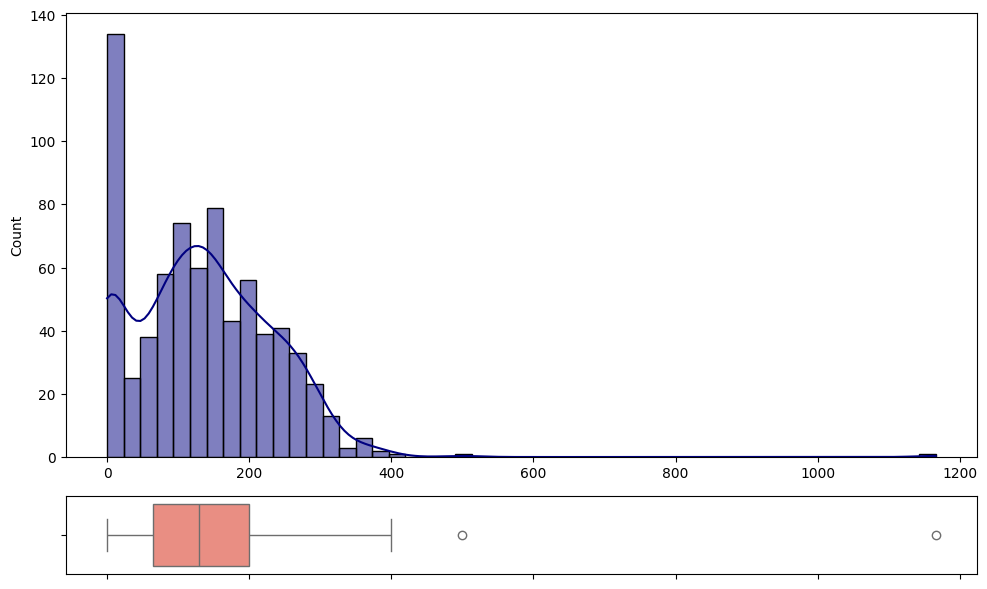

In [37]:
f, (ax_hist, ax_box) = plt.subplots(2, sharex=True, 
                                    gridspec_kw={"height_ratios": (.85, .15)},
                                    figsize=(10, 6))

sns.boxplot(data=pp_day, x='purchases', ax=ax_box, color="salmon")
sns.histplot(data=pp_day, x='purchases', ax=ax_hist, kde=True, color="navy", bins = 50)
ax_box.tick_params(labelbottom=False)
ax_hist.tick_params(labelbottom=True)
ax_box.set(xlabel='')

plt.tight_layout()
plt.show()

Las cantidades de órdenes por día suelen ser entre 60 y 200 veces por día. Se detectan dos outliers que significan dos cantidades mucho más altes de órdenes por día.

Realizaremos una gráfica de Tiempo vs Órdenes por día

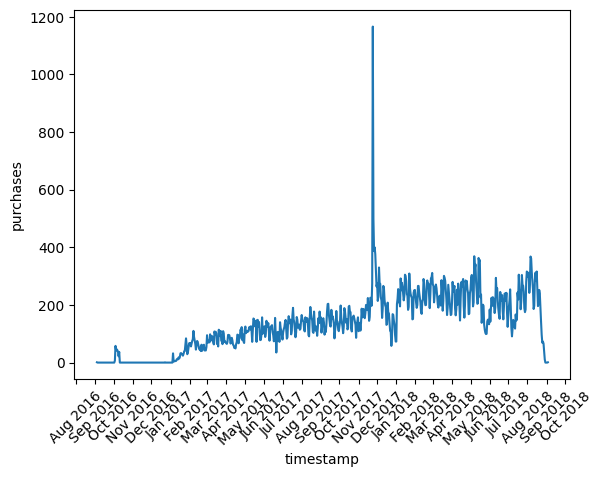

In [38]:
import matplotlib.dates as mdates

ax = sns.lineplot(data=pp_day, x='timestamp',y = 'purchases')

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.show()



Se observa claramente una subida repentina en noviembre de 2017; se analizarán cuáles eran los dos outliers y la razón de esta cantidad masiva de órdenes en noviembre.

In [39]:
pp_day.sort_values(by='purchases',ascending=False).head(15)

,timestamp,purchases,revenue
446,2017-11-24,1166,178450.11
447,2017-11-25,499,71897.01
449,2017-11-27,400,56644.83
448,2017-11-26,387,53247.48
450,2017-11-28,376,56248.48
610,2018-05-07,369,61418.70
701,2018-08-06,368,63129.90
617,2018-05-14,363,62053.90
702,2018-08-07,361,57325.15
619,2018-05-16,356,64688.87


Aquí se observa que las 5 primeras fechas corresponden al periodo desde el 24 de noviembre hasta el 28 de noviembre de 2017 (y el 29 de noviembre también está incluido en el top 15). Estas fechas corresponden al periodo de *Black Friday* en Brasil en ese año, lo cual explica la cantidad masiva de compras. Por otro lado, las otras fechas con alta cantidad de órdenes pertenecen principalmente a mayo y agosto de 2018, lo que podría deberse al Día de la Madre y del Padre, respectivamente. Por último, en el top 14 se encuentra una fecha de diciembre, la cual podría atribuirse a las celebraciones navideñas.


Se quitarán los cinco primeros días de *black friday* para analizar un comportamiento más general de órdenes y ganancias.

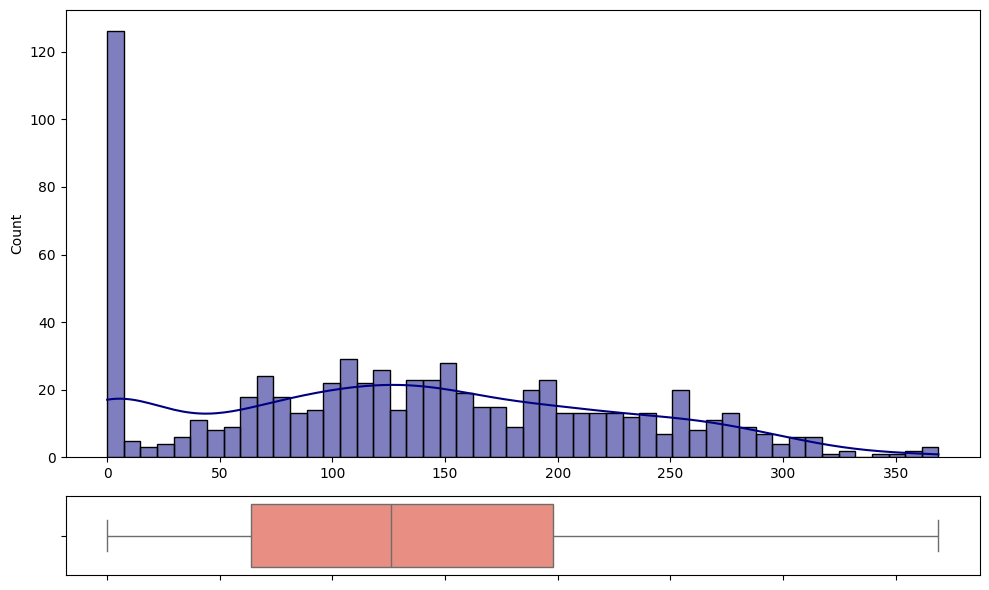

In [40]:
pp_day_bf_out = pp_day[pp_day['purchases'] < 376]

f, (ax_hist, ax_box) = plt.subplots(2, sharex=True, 
                                    gridspec_kw={"height_ratios": (.85, .15)},
                                    figsize=(10, 6))

sns.boxplot(data=pp_day_bf_out, x='purchases', ax=ax_box, color="salmon")
sns.histplot(data=pp_day_bf_out, x='purchases', ax=ax_hist, kde=True, color="navy", bins = 50)
ax_box.tick_params(labelbottom=False)
ax_hist.tick_params(labelbottom=True)
ax_box.set(xlabel='')

plt.tight_layout()
plt.show()

Ahora se observa un comportamiento mucho más normalizado y sin outliers. Algo a destacar es la enorme cantidad de días sin órdenes, aunque estos corresponden principalmente a los inicios (cuando la popularidad de Olist era baja) y finales (donde hay una falta de datos) del conjunto de datos. A continuación, se examinará nuevamente la gráfica de órdenes versus tiempo.

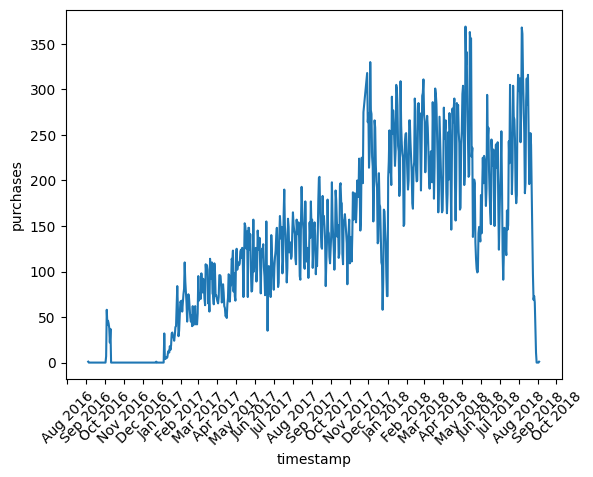

In [41]:
ax = sns.lineplot(data=pp_day_bf_out, x='timestamp',y = 'purchases')

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.show()

Ahora la gráfica muestra un crecimiento con el paso del tiempo, esto significa que la popularidad de Olist ha ido en aumento principalmente desde inicios de 2017.

### Ganancias por dia

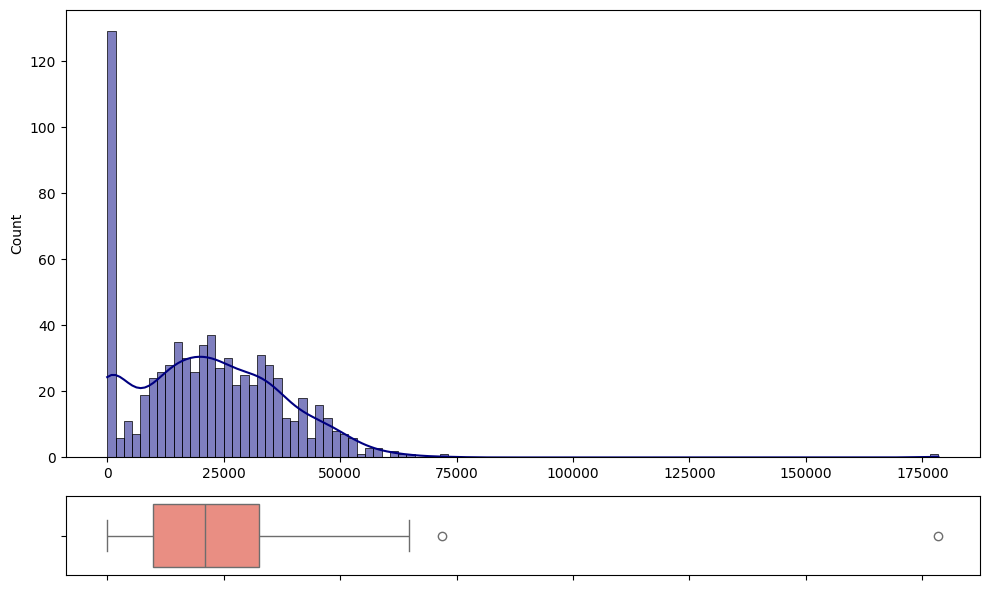

In [42]:
f, (ax_hist, ax_box) = plt.subplots(2, sharex=True, 
                                    gridspec_kw={"height_ratios": (.85, .15)},
                                    figsize=(10, 6))

sns.boxplot(data=pp_day, x='revenue', ax=ax_box, color="salmon")
sns.histplot(data=pp_day, x='revenue', ax=ax_hist, kde=True, color="navy", bins = 100)
ax_box.tick_params(labelbottom=False)
ax_hist.tick_params(labelbottom=True)
ax_box.set(xlabel='')

plt.tight_layout()
plt.show()

Aquí nuevamente se observan dos outliers que muy probablemente encajen de igual forma con los dos puntos atípicos dedicados a la cantidad de órdenes.

In [43]:
pp_day.sort_values(by='revenue',ascending=False).head(15)

,timestamp,purchases,revenue
446,2017-11-24,1166,178450.11
447,2017-11-25,499,71897.01
619,2018-05-16,356,64688.87
701,2018-08-06,368,63129.90
617,2018-05-14,363,62053.90
610,2018-05-07,369,61418.70
613,2018-05-10,278,57719.25
645,2018-06-11,294,57345.56
702,2018-08-07,361,57325.15
449,2017-11-27,400,56644.83


Si bien los dos outliers encajan, aquí el orden varía un poco, lo que muestra que después de los dos primeros días de *Black Friday*, los meses de mayo y agosto, correspondientes a las fechas del Día de la Madre y del Padre, respectivamente, generaron más ganancias por día que el resto de los días de *Black Friday* (del 27 al 29). 

Se ve claramente los outliers de *black friday*. Se usará el Dataframe `pp_day_bf_out` generado anteriormente para visualizar un comportamiento general de ganancias por día.

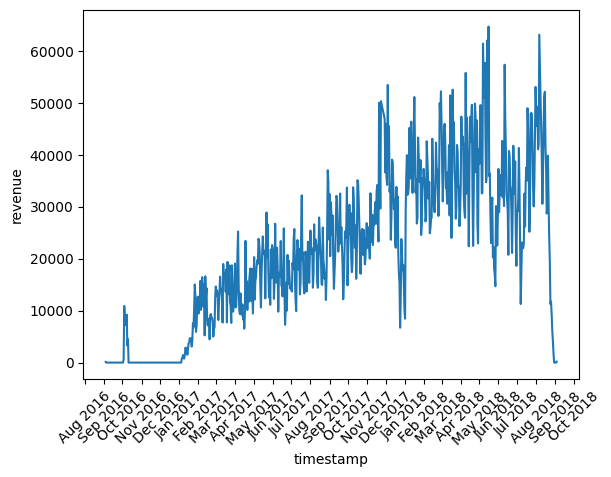

In [44]:
ax = sns.lineplot(data=pp_day_bf_out, x='timestamp',y = 'revenue')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.show()

Aquí nuevamente se puede comprobar un crecimiento general de la empresa.

### Relación entre cantidad de órdenes y ganancias por día

A continuación, se examinará la cantidad de ganancias por día para comparar si una cantidad alta de órdenes se traduce en una cantidad alta de ganancias.

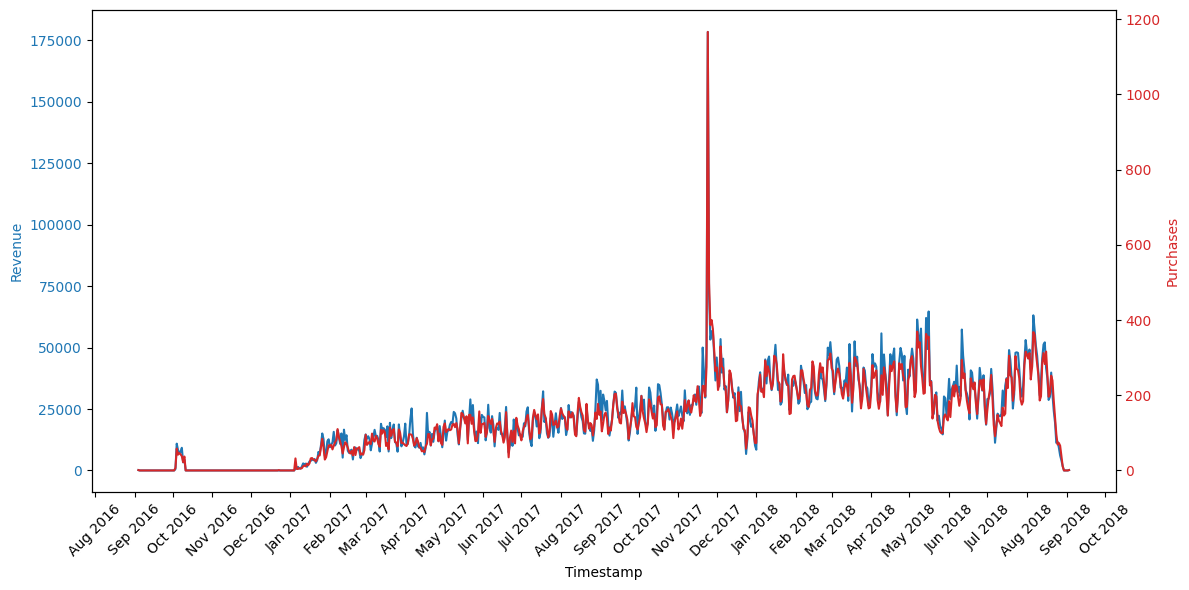

In [45]:
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Revenue', color=color)
sns.lineplot(data=pp_day, x='timestamp', y='revenue', ax=ax1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:red'
ax2.set_ylabel('Purchases', color=color)
sns.lineplot(data=pp_day, x='timestamp', y='purchases', ax=ax2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))


plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

Se ve un comportamiento bastante esperado y positivo, con cierta proporción entre la cantidad de órdenes y la ganancia generada.

## Ticket promedio (Average Transaction Value)

Se hará un análisis más profundo sobre el gasto de cada órden, para esto se extraerá del dataset directamente cada órden, su fecha (timestamp) y el valor de la órden.


In [46]:
query_orders_date = """
SELECT 
    o.order_id,
	o.order_purchase_timestamp,
    SUM(p.payment_value) AS total_value
FROM orders o
JOIN order_payments p ON o.order_id = p.order_id
WHERE p.payment_value > 0 AND o.order_status NOT IN ('canceled','unavailable')
GROUP BY o.order_id
"""
orders_date = pd.read_sql(query_orders_date,engine)
orders_date['order_purchase_timestamp'] = pd.to_datetime(orders_date['order_purchase_timestamp']).dt.normalize()
orders_date.head()

,order_id,order_purchase_timestamp,total_value
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13,72.19
1,00018f77f2f0320c557190d7a144bdd3,2017-04-26,259.83
2,000229ec398224ef6ca0657da4fc703e,2018-01-14,216.87
3,00024acbcdf0a6daa1e931b038114c75,2018-08-08,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,2017-02-04,218.04


In [47]:
orders_date.dtypes

order_id                               str
order_purchase_timestamp    datetime64[us]
total_value                        float64
dtype: object

In [48]:
orders_date['total_value'].agg(['mean','median','min','max'])

mean        160.266552
median      105.280000
min           9.590000
max       13664.080000
Name: total_value, dtype: float64

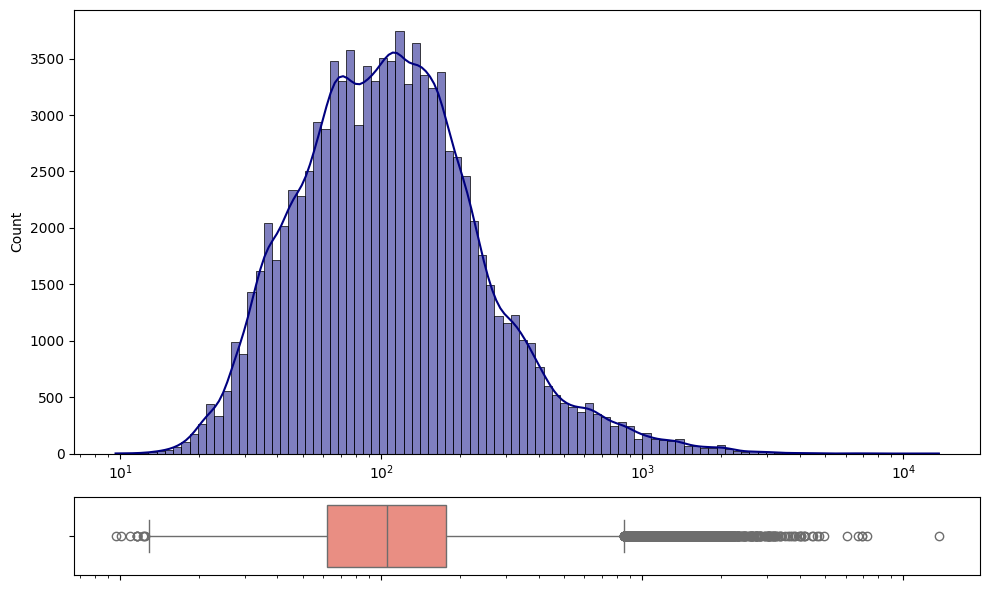

In [49]:
f, (ax_hist, ax_box) = plt.subplots(2, sharex=True, 
                                    gridspec_kw={"height_ratios": (.85, .15)},
                                    figsize=(10, 6))

sns.boxplot(data=orders_date, x='total_value', ax=ax_box, color="salmon", log_scale= True)
sns.histplot(data=orders_date, x='total_value', ax=ax_hist, kde=True, color="navy", bins = 100, log_scale= True)
ax_box.tick_params(labelbottom=False)
ax_hist.tick_params(labelbottom=True)
ax_box.set(xlabel='')

plt.tight_layout()
plt.show()

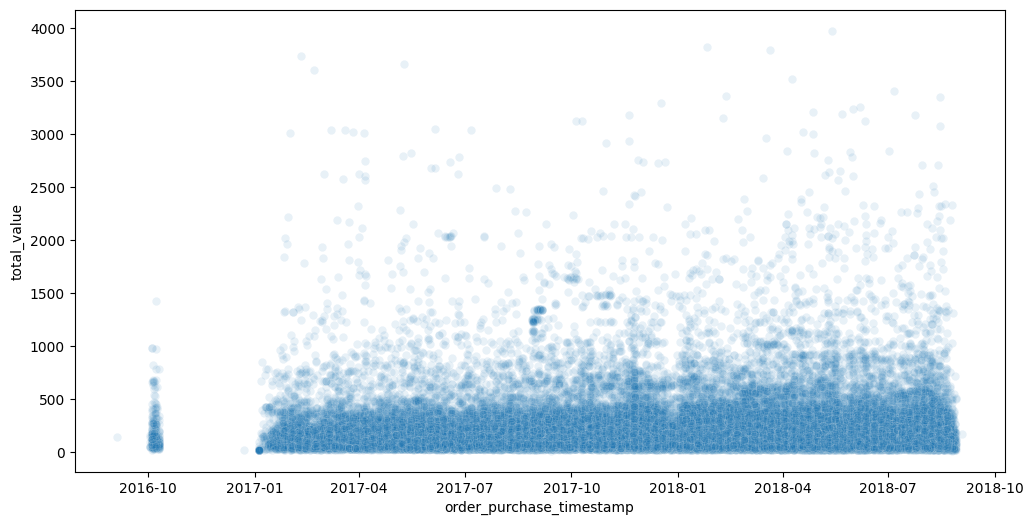

In [50]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=orders_date[orders_date['total_value'] < 4000], x='order_purchase_timestamp', y='total_value', alpha = 0.1)

plt.show()

In [ ]:
f, (ax_hist, ax_box) = plt.subplots(2, sharex=True, 
                                    gridspec_kw={"height_ratios": (.85, .15)},
                                    figsize=(10, 6))

sns.boxplot(data=pp_day[pp_day['ATV'] > 0], x='ATV', ax=ax_box, color="salmon")
sns.histplot(data=pp_day[pp_day['ATV'] > 0], x='ATV', ax=ax_hist, kde=True, color="navy", bins = 50)
ax_box.tick_params(labelbottom=False)
ax_hist.tick_params(labelbottom=True)
ax_box.set(xlabel='')

plt.tight_layout()
plt.show()

Se logra ver una distribución normal, 

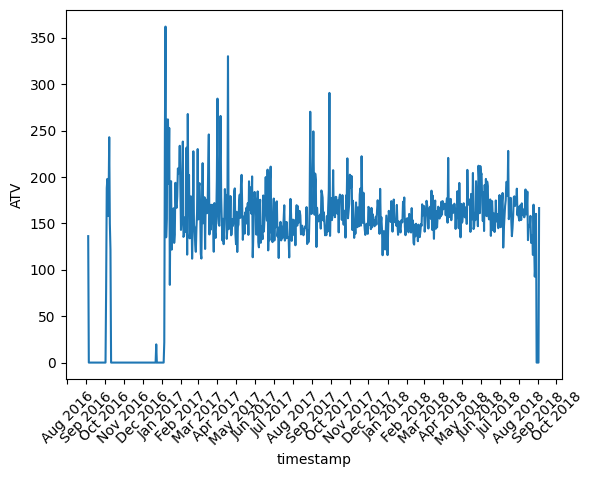

In [ ]:
ax = sns.lineplot(data=pp_day, x='timestamp',y = 'ATV')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.show()